# Semantic Segmentation for Self Driving Cars

- Dataset: https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge

We import the dataset from Kaggle, sourced from the Lyft-Udacity Challenge, is designed for autonomous driving applications, comprising thousands of labeled images. It features diverse urban scenes with pixel-wise annotations for semantic segmentation, including vehicles, roads, and pedestrians, ideal for training deep learning models for self-driving cars.


- Description:

This document outlines a comprehensive approach to developing a semantic segmentation model, specifically tailored for applications in self-driving car technologies. Our method leverages a U-Net architecture, renowned for its effectiveness in distinguishing between different objects within an image by classifying each pixel into a predefined category. With a focus on operational efficiency, the model undergoes a series of transformations, including resizing and normalization, to ensure compatibility with the U-Net framework. We meticulously build, compile, and train our model, employing strategies such as data augmentation and early stopping to enhance performance and mitigate overfitting.

# Content
- 1. Importing Libraries / Loading Data from Kaggle Dataset
- 2.
  - 2-1. Showing the Images and Masks
  - 2-2. Storing images and masks paths
  - 2-3. Observing the Lists Generated Recently.
- 3.
  - 3-1. The provided code appears to be related to preparing datasets for image segmentation tasks using TensorFlow
  - 3-2. Converting the Lists to Tensors
  - 3.3. Combining images and masks into pairs
- 4. Doing the Preprocess about Images and Masks
- 5. Identifying the Total Number of Distinct Classes
- 6. Build an improved U-Net model (U-Net V2) architecture
- 7. Model Setup and Configuration
- 8. Outline of the Model's Structure
- 9. Preparing the Model for Training
- 10. Visualizing Input and Output Data
- 11. Training Models
- 12. Method for Interpreting Prediction Masks
- 13. Evaluating the Model's Learning Outcome
- 14. Demonstrating Model Predictions
- 15. Making Predictions with the Trained Model


# 1 : Importing Libraries / Loading Data from Kaggle Dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: trunghaunguyen29
Your Kaggle Key: ··········


100%|██████████| 5.11G/5.11G [00:57<00:00, 95.7MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, ReLU

# 2-1: Showing the Images and Masks

In [ ]:
def display_images(data, no_img_mask):
    images = glob.glob('/content/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png')[:no_img_mask]
    masks = glob.glob('/content/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png')[:no_img_mask]

    for i in range(len(images)):
        images[i] = cv2.imread(images[i])
        masks[i] = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(no_img_mask, 2) # creates a grid of subplots with no_img_mask rows and 2 columns.

    for i in range(len(images)):
        axes[i][0].imshow(images[i])
        axes[i][1].imshow(masks[i])

    plt.show()

**display_images(A, B): A is the folder name. B is the number of image-mask pairs to display.**

**First column display the pictures from the dataset, and the second column display the pictures that change to greyscale and convert into corresponding masks**

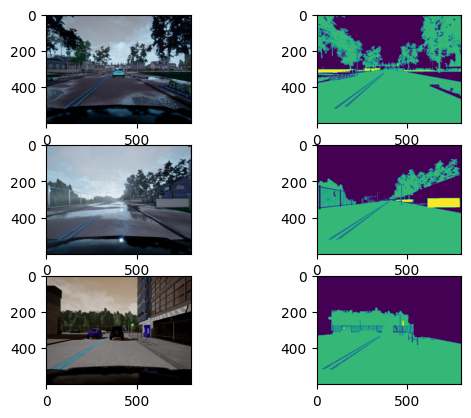

In [ ]:
display_images('dataD', 3)

# 2-2. Storing images and masks paths
**store_imgs_masks() is designed to store the file paths of images and masks for a given dataset.**

**glob.glob() to find all the file paths matching the specified pattern for images and masks in the dataset directory.**

In [ ]:
images_list = []
masks_list = []

In [ ]:
def store_imgs_masks(data):
    images_list.append(glob.glob('/content/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png'))
    masks_list.append(glob.glob('/content/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png'))

In [ ]:
store_imgs_masks('dataA')
store_imgs_masks('dataB')
store_imgs_masks('dataC')
store_imgs_masks('dataD')
store_imgs_masks('dataE')


# 3-1: Converting the Lists of Images and Masks into lists for images and masks.
Consolidates the lists of image and mask paths into singular lists to streamline the data preparation process for segmentation tasks.

In [ ]:
def get_one_list(list_of_lists):

    one_list = []

    for sublist in list_of_lists:
        one_list.extend(sublist)
    return one_list

In [ ]:
images_list = get_one_list(images_list)
masks_list = get_one_list(masks_list)

In [ ]:
print(images_list[100], '\n')
print(masks_list[100])

/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/07_00_050.png 

/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/07_00_050.png


# 3-2: Converting the Lists to Tensors
Converts these lists into TensorFlow data structures (tensors), facilitating batch processing and model input compatibility.

In [ ]:
image_list_ds = tf.data.Dataset.list_files(images_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(masks_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)


# 3-3: Combining images and masks into pairs
Combines images and masks into pairs, ensuring each image is correctly matched with its segmentation mask, critical for training accuracy.

In [ ]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/F5-71.png', shape=(), dtype=string)
tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/F5-71.png', shape=(), dtype=string)


# 4: Doing the Preprocess about Images and Masks
Applies transformations such as resizing and normalization to the images and masks to prepare them for model input, ensuring consistency and improving model training efficiency.

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # normalization

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

# 5: Identifying the Total Number of Distinct Classes
Determines the unique classes in the dataset by analyzing the masks.
It is essential for configuring the output layer of the segmentation model and loss calculation.

In [ ]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))

print(uniques)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


# 6: Build an U-Net model architecture

We were choosing U-Net because the model has the skip connections, it will capture the best feature from the encoder to the decoder, and it works well for semantic segmentation problem.

## Encoder 

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0):
    layer = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
    layer = BatchNormalization(axis=3)(layer,training=True)
    layer = ReLU()(layer)
    layer = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(layer)
    layer = BatchNormalization(axis=3)(layer,training=True)
    layer = ReLU()(layer)

    if dropout_prob > 0:
        layer = Dropout(dropout_prob)(layer)

    return layer

## 7: Assembling the Neural Network Model
Utilizes the previously defined U-Net architecture to assemble the model, specifying input size, number of filters, number of classes, and also design the skip connections.

In [ ]:
def unet_model(input_size=(96,128,3), n_filters=32, n_classes = 13):
    inputs = Input(input_size)
    # Encoder
    conv1 = conv_block(inputs, n_filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, n_filters * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, n_filters * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, n_filters * 8, dropout_prob=0.3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv_block(pool4, n_filters * 16, dropout_prob=0.3)


    # Decoder
    up6 = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(conv5)
    merge6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(merge6, n_filters * 8)

    up7 = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(merge7, n_filters * 4)

    up8 = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(merge8, n_filters * 2)

    up9 = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1], axis=3)
    conv9 = conv_block(merge9, n_filters)


    # Outputs
    outputs = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(conv9)
    outputs = BatchNormalization(axis=3)(outputs,training=True)
    outputs = ReLU()(outputs)
    outputs = Conv2D(n_classes, 1, padding='same')(outputs)
    outputs = BatchNormalization(axis=3)(outputs,training=True)
    outputs = ReLU()(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# 7: Model Setup and Configuration

In [ ]:
img_height = 192
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

# 8: Outline of the Model's Structure

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 192, 256, 32)         0         ['batch_normalization[0][0

# 9: Preparing the Model for Training
Prepares the model for training by specifying the optimizer, loss function, and metrics.

In [ ]:
unet.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# 10: Visualizing Input and Output Data
Demonstrates a function to visualize the input image, true mask, and predicted mask

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

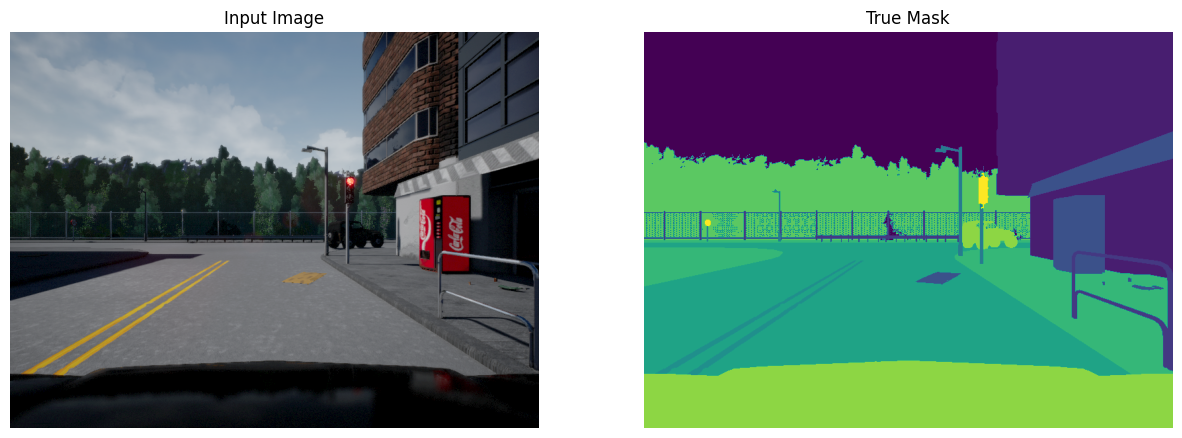

In [ ]:
for image, mask in image_ds.take(2):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# 11: Training Models
Details the training process, including setting epochs, batch size, and dataset partitioning into training, validation, and test sets

In [ ]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [ ]:
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples)).take(int(0.15 * num_samples))
test_dataset = map_dataset.skip(int(0.95 * num_samples))

print(processed_image_ds)

filepath = "/content/model_checkpoint_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(patience=3)


<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [ ]:
model_history = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[checkpoint, early_stop])

Epoch 1/50
63/63 [==============================] - 162s 2s/step - loss: 1.4490 - accuracy: 0.7597 - val_loss: 1.0716 - val_accuracy: 0.8991
Epoch 2/50
63/63 [==============================] - 105s 2s/step - loss: 0.9811 - accuracy: 0.9098 - val_loss: 0.9077 - val_accuracy: 0.9183
Epoch 3/50
63/63 [==============================] - 105s 2s/step - loss: 0.8458 - accuracy: 0.9253 - val_loss: 0.8000 - val_accuracy: 0.9301
Epoch 4/50
63/63 [==============================] - 109s 2s/step - loss: 0.7538 - accuracy: 0.9333 - val_loss: 0.7011 - val_accuracy: 0.9412
Epoch 5/50
63/63 [==============================] - 105s 2s/step - loss: 0.6630 - accuracy: 0.9446 - val_loss: 0.6288 - val_accuracy: 0.9485
Epoch 6/50
63/63 [==============================] - 105s 2s/step - loss: 0.5941 - accuracy: 0.9505 - val_loss: 0.5634 - val_accuracy: 0.9536
Epoch 7/50
63/63 [==============================] - 104s 2s/step - loss: 0.5380 - accuracy: 0.9548 - val_loss: 0.5112 - val_accuracy: 0.9569
Epoch 8/50
63

In [ ]:
score = unet.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05899166688323021
Test accuracy: 0.9882141947746277


# 12: Method for Interpreting Prediction Masks
To convert model predictions into a mask format that can be visualized or measured.

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# 13: Evaluating the Model's Learning Outcome
Illustrates the model's learning progress by charting the training and validation accuracy and loss metrics across epochs, offering insights into its performance and learning curve.

In [ ]:
acc = model_history.history["accuracy"]
val_acc = model_history.history["val_accuracy"]
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

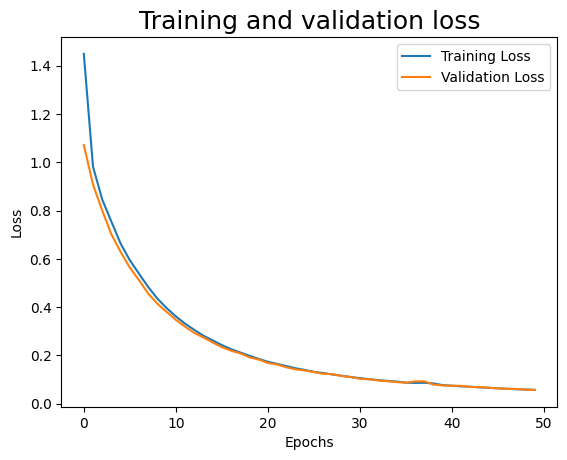

In [ ]:
# Plot training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and validation loss",fontsize=18)
plt.show()

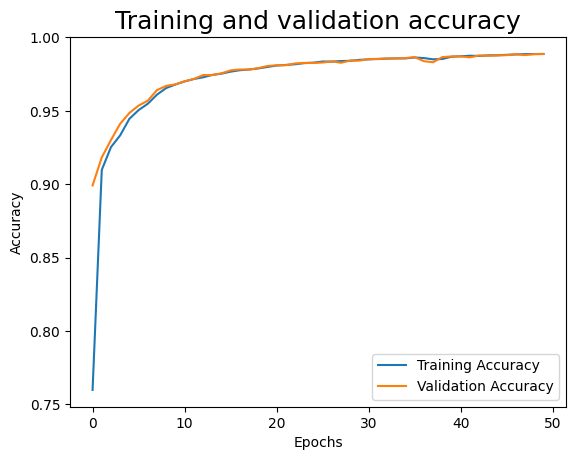

In [ ]:
# Plot training and validation loss
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and validation accuracy",fontsize=18)
plt.show()

This model training accuracy reaches 98.88%, closely matched by a validation accuracy of 98.87%, suggesting the model performs excellently on both seen and unseen data without significant overfitting. 

This model's performance, characterized by high accuracy and low loss in both phases, demonstrates its potential efficacy for its intended application, reflecting a well-optimized training process.

# 14: Demonstrating Model Predictions

In [ ]:
def show_predictions(unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 10s 31ms/step


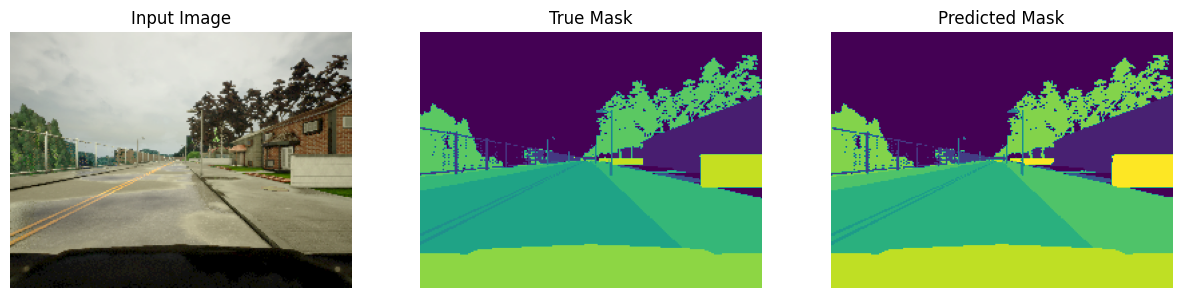

2/2 [==============================] - 0s 179ms/step


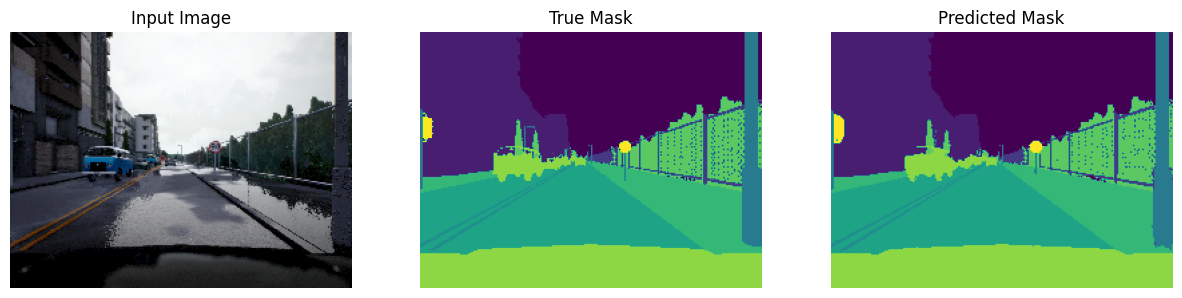

2/2 [==============================] - 0s 180ms/step


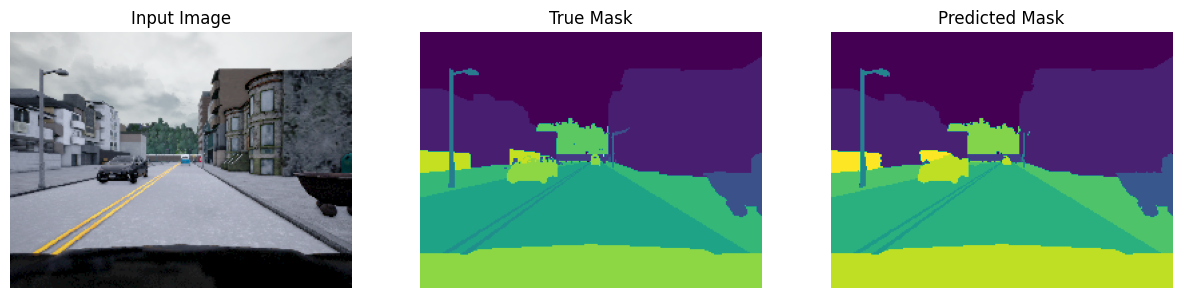

1/1 [==============================] - 1s 608ms/step


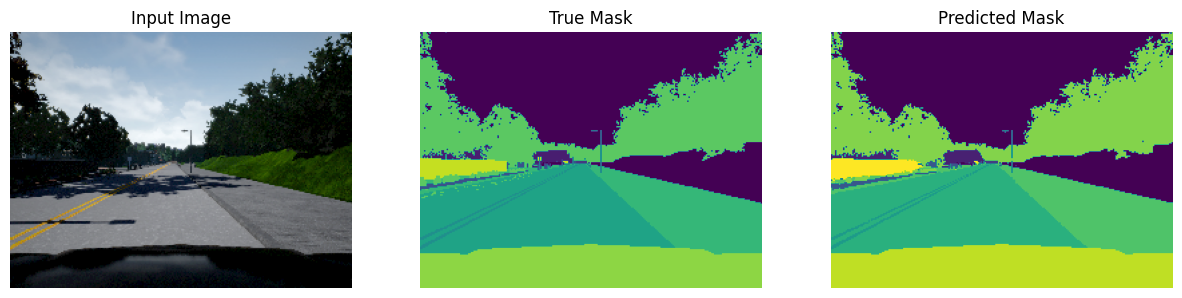

In [ ]:
show_predictions(unet,test_dataset, 6)

The predicted masks generated by the model closely resemble the true masks, suggesting the model is performing well. It's apparent that key features of the road, vehicles, and the environment are mostly captured. However, there are discrepancies in the finer details, such as the segmentation boundaries of smaller objects and slight misclassifications of areas. These imperfections are common in semantic segmentation tasks and can be improved with further training, data augmentation, or more sophisticated models. Overall, the model capture the broad structure of the scenes effectively, which is crucial for the intended application in autonomous driving.

# 15: Making Predictions with the Trained Model

In [ ]:
image = cv2.imread('/content/mqdefault.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (256, 192))

1/1 [==============================] - 0s 22ms/step


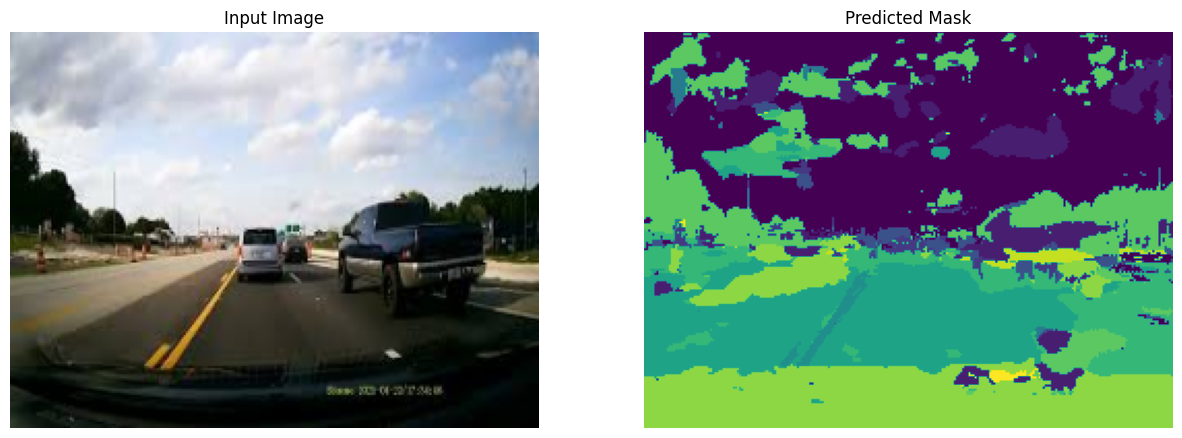

In [ ]:
prediction = unet.predict(np.expand_dims(resized_image, axis=0))
# Display images
display([resized_image, create_mask(prediction)])

The predicted mask seems to struggle with accurately capturing and delineating the various elements within the scene. 
The segmentation appears to be imprecise, with several areas of the road and vehicles not distinctly outlined. Additionally, the segmentation mask presents a significant amount of noise, particularly in areas that should represent a single category, such as the road surface. 

In [ ]:
image2 = cv2.imread('/content/maxresdefault.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
resized_image2 = cv2.resize(image2, (256, 192))

1/1 [==============================] - 0s 23ms/step


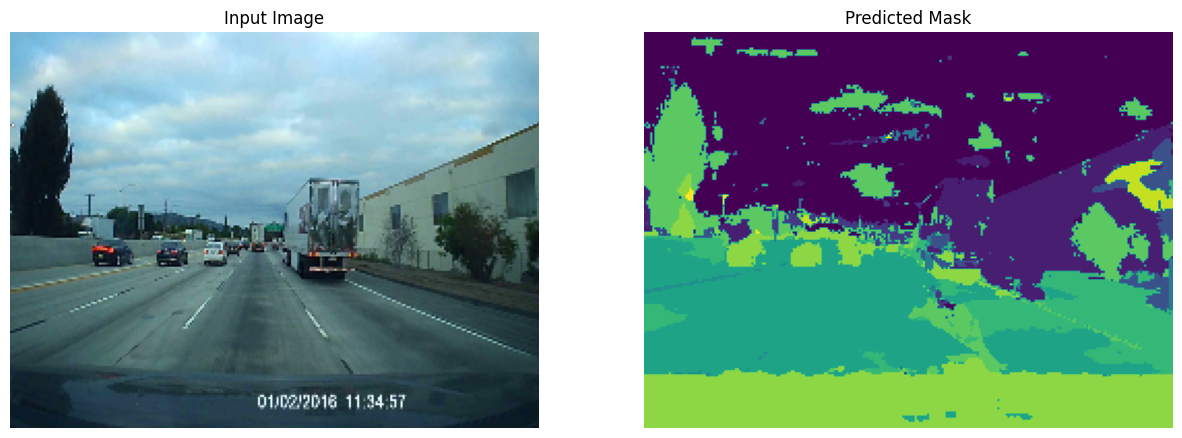

In [ ]:
prediction = unet.predict(np.expand_dims(resized_image2, axis=0))
# Display images
display([resized_image2, create_mask(prediction)])

The predicted mask identify the road and differentiating between the sky and vehicles, but exhibits a lack of precision in the boundaries between classes and with some misclassified regions.

For example, vehicles are not consistently segmented, and there are noticeable areas where the road and the vehicles blend into each other. The model does capture the larger shapes, like the broad expanse of the road, but details like vehicle contours and separation from the road require refinement. 

There's also evident confusion between the sky and the tree line, indicating potential room for improvement in the model’s ability to distinguish between similarly colored but distinct categories.

# Saving the model

In [ ]:
tf.keras.models.save_model(unet, '/content/model.h5')

<ipython-input-34-45d366f38bf2>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(unet, '/content/model.h5')
